### Visual Place Recognition + Cut Graph Evaluation

This code implements the Visual Place Recognition (VPR) system and the criteria to evaluate the topology of places resulting from the recursive bipartition of the Appearance Graph.

### Libreries

In [141]:
import h5py
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from Utils import geometry2 as geo
from Utils import load_utils
from sklearn.metrics import confusion_matrix
import seaborn as sns


### Auxliar Functions

In [142]:
def get_descriptor(general_path):
    # Function to read the global descriptors of an h5py file
    descriptors=[]
    for suffix in os.listdir(general_path):
        f=h5py.File(general_path+suffix,'r')
        descriptors+=f['features']
    return np.array(descriptors)

In [143]:
def pose_mean_cov(map_dataset):
    # Function to calculate the mean and the covariance matrix of the distributions of poses of the groups.
    # Also computes the mean of the appearance descriptors for each group, called centroids.

    # Initialization of variables
    mean_pose=[]
    mean_feats=[]
    cov_pose=[]

    # The groups of the topology are traversed
    for cl in map_dataset['clusters_list']:
        poses=map_dataset['poses'][cl]  # Mean in group poses
        feats=map_dataset['feats'][cl]  # Mean in group appearance, centroid

        # Computes the pose and the covariance matrix in SE(2)
        poses_mean, poses_cov = geo.get_mean_covariance(poses)
        feats_mean=np.mean(feats,axis=0)

        # Save the results in the lists:
        mean_pose.append(poses_mean)
        mean_feats.append(feats_mean)
        cov_pose.append(poses_cov)

        del poses_mean, poses_cov, feats_mean
    
    # Save the result in the dictionary of the topological map:
    map_dataset['poses_mean']=mean_pose
    map_dataset['feats_mean']=mean_feats
    map_dataset['poses_cov']=cov_pose
    
    return mean_pose, cov_pose

## APPEARANCE DISTANCE
This part implements the criteria to determine the distance between image descriptors, it is used in the VPR process to assign a query to a group.

### Functions to calculate the distance in appearance between queries and places on the topological map

In [144]:
cos_sim=lambda x,y:np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))    # Cosine similarity
euc_sim= lambda x,y: np.linalg.norm(np.array(x)-np.array(y))            # Euclidean distance

Cosine similarity criterion

In [145]:
def app_dist_cos(query_descriptors,map_descriptors):
    distances=[[cos_sim(query_descriptors[j],map_descriptors[i])for i in range(len(map_descriptors))]for j in range(len(query_descriptors))]
    return np.array(distances)

Minimum Euclidean distance criterion

In [146]:
def app_dist_euc(query_descriptors,map_descriptors):
    distances=[[euc_sim(query_descriptors[j],map_descriptors[i])for i in range(len(map_descriptors))]for j in range(len(query_descriptors))]
    return np.array(distances)

### Criterion 1: Most similar centroid

This criterion measures the distance between each query and the centroids of the groups.

Returns the group to which the query belongs based on the min/max distance to the centroids.

In [147]:
def most_similar_centroid(query_descriptors, map_dataset, criterion='COS'):

    if criterion == 'COS':      # Cosine similarity
        distances=app_dist_cos(query_descriptors,map_dataset['feats_mean']) # Calculates cosine similarity for all queries with respect to map centroids
        return np.argmax(np.array(distances),axis=1)    # The maximum value of the cosine similarity for each query gives us the group to which it belongs
    
    elif criterion == 'EUC':    # Euclidean distance 
        distances=app_dist_euc(query_descriptors,map_dataset['feats_mean']) # Calculation of the Euclidean distance for all queries with respect to the centroids of the map
        return np.argmin(np.array(distances),axis=1)    # The minimum value of the Euclidean distance for each query gives us the group to which it belongs
    
    else:
        print('CRITERION ERROR: not valid')
    

### Criterion 2: k-most similar images

This criterion measures the distance in appearance for all the elements of the topological map, it returns the closest k

This criterion was used in the research but was finally discarded from the final results.

In [148]:
def k_similar(query_descriptors, map_dataset, k, criterion='COS'):

    if criterion=='COS':     # Cosine similarity
        distances=app_dist_cos(query_descriptors,map_dataset['feats']) # Calculates cosine similarity for all queries with all map descriptors
        idx=np.argsort(np.array(distances),axis=1)                     # Order the distances from least to greatest.
        img=idx[:][-k:]      # The k closest elements are chosen

        # The groups to which the k closest elements belong are calculated
        tam=len(query_descriptors)
        cl=np.array([[map_dataset['clusters_idx'][idx[i][-j]] for j in range(1,k+1)] for i in range(tam)])  

        return cl, img
    
    elif criterion=='EUC':   # Euclidean distance
        distances=app_dist_euc(query_descriptors,map_dataset['feats']) # Calculates the Euclidean distance for all queries with all map descriptors
        idx=np.argsort(np.array(distances),axis=1)                     # Order the distances from least to greatest.
        img=idx[:,:k]        # The k closest elements are chosen

        # The groups to which the k closest elements belong are calculated
        tam=len(query_descriptors)
        cl=np.array([[map_dataset['clusters_idx'][idx[i][j]] for j in range(k)] for i in range(tam)])  # The groups to which the k closest elements belong are calculated
        
        return cl, img
    
    else:
        print('CRITERION ERROR: not valid')

## POSE DISTANCE
In this section the different criteria are implemented to determine the distance in pose between the queries and the groups of the map.

### Criterion 1: Mode of K-neighbors SE2 Pose

This criterion measures the distance in SE(2) from the poses in the query to each pose in the map and calculates the K nearest neighbor. Returns the groups to which the majority of the k-neighbors belong.

In [149]:
def get_mode(List):
    # Function to calculate the mode in a list of groups of the topological map
    aux=np.zeros(max(List)+1).tolist()
    for item in List:
        aux[item]+=1
    return np.argmax(aux)

In [150]:
def mode_K_Neighbours(query_poses, map_dataset, thr_ang, k=5):
    # Return array, with the groups to which each query belongs
    res=[]

    # Combine the map poses into a SE(2) class
    map_poses=geo.combine(map_dataset['poses'])
    
    for i in range(len(query_poses)):
        pq=query_poses[i]   # Query pose

        # Calculates the composition of poses of each query to all the poses of the map
        incre= pq / map_poses
        dist=[np.linalg.norm(incre.t()[i]) for i in range(len(incre))]  # Extract the translation
        ang_dist=(incre.R().as_euler('xyz'))[:,2]                       # Extract the rotation

        # Sort the distances from least to greatest
        sort_idx=np.argsort(dist)
        
        assert len(dist) > k 

        # Loop to calculate the groups of the k closest elements within the angular distance threshold
        temp_idx=[]
        for j in sort_idx:
            if np.abs(ang_dist[j]) < thr_ang:               # Ensure that it meets the threshold in the angular distance
                cluster_idx=map_dataset['clusters_idx'][j]  # Index of the group to which the k elements belong
                temp_idx.append(cluster_idx) 
            if len(temp_idx)>=k: break  # When the number of indices exceeds the value k the loop stops
        
        # Call the 'get_mode' function to calculate the mode of the k cluster indices for each query
        res.append(get_mode(temp_idx))
        
    return res
         

### Criterion 2: Most nearest image

This criterion returns the group whose element has the smallest distance in SE(2) for each query, considering it the closest group.

In [151]:
def nearest(query_poses, map_dataset, thr_ang=0.3):
    # Return array, with the groups to which each query belongs
    res=[]

    # Combine the map poses into a Se(2) class
    map_poses=geo.combine(map_dataset['poses'])
    
    # For each query:
    for i in range(len(query_poses)):
        pq=query_poses[i]   # Pose query

        # Calculate composition of poses between the query and the elements of the topological map
        incre= pq / map_poses
        dist=[np.linalg.norm(incre.t()[i]) for i in range(len(incre))]  # Extract the translation
        ang_dist=(incre.R().as_euler('xyz'))[:,2]                       # Extract the rotation

        # Sort the distances from least to greatest
        sort_idx=np.argsort(dist)

        # Loop to obtain the topology group with element closest to the query
        for j in sort_idx:
            if np.abs(ang_dist[j]) < thr_ang:               # Ensure that it meets the threshold in the angular distance
                res.append(map_dataset['clusters_idx'][j])  # For each query, the map group whose element is at the shortest distance is assigned.
                break
            
    return res

### Criterion 3: Mahalanobis Distance

This criterion implements the Mahalanobis distance between a set of queries and the distributions of poses of the elements of the topology.

For this, the mean and the covariance matrix of each distribution are used.

In [152]:
def mahdist_to_cluster(query_dataset,map_dataset,select_idx):
    mahdist=[]
    
    # The query poses array is traversed:
    for pose in query_dataset['poses'][select_idx]:
        distances=[]
        # The Mahalanobis distance from the query pose to each group is computed with the geometry2 library.
        for idx in range(len(map_dataset['poses_mean'])):
            distances.append(geo.multivariate_mahalannobis(pose,
                                                          map_dataset['poses_mean'][idx],
                                                          map_dataset['poses_cov'][idx]))
        mahdist.append(np.array(distances).T)
    
    return np.array(mahdist)

## EVALUATION CRITERIA
In this part, the two evaluation criteria used to evaluate the proposed place topology are implemented.

### Criterion 1: Multiclass Confusion Matrix

With this criterion, the Multiclass Confusion Matrix for the VPR system is calculated.

Precision and recall are extracted from it, both at the group level and at the general level.

In [153]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
#   Function to plot multiclass confusion matrix with annotations.
#   - Input: 
#         y_true    ---> True value (ground-truth) of queries
#         y_pred    ---> Group prediction of queries
#         labels    ---> Labels of query classes, array of string
#         figsize   ---> Plot size

    # Calculate the multiclass confusion matrix with the sklearn method
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]

                annot[i, j] = '%d' % (c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%d' % (c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Ground truth'
    cm.columns.name = 'Prediction'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap='BuPu',vmin=0, vmax=10,linewidths=1,linecolor='black')
    plt.title("Multiclass confusion matrix")

In [154]:
def confusion_mat(query_GT, query_predict, n_clusters):
#   Calculate the multiclass confusion matrix for all groups in the topological map
#   Result different from the sklearn cm method, useful for evaluation of Precision and Recall at group level
#   - Input: 
#         query_GT          ---> True value (ground-truth) of queries
#         query_predict     ---> Query group prediction
#         n_cluster         ---> Total number of clusters in the topological map
#   - Output:
#         confm             ---> Multiclass confusion matrix

    # Initialize the multiclass confusion matrix
    tam=n_clusters # Number of total groups
    confm=np.reshape(np.zeros(tam**2),[tam,tam])

    # Fill in the boxes of the multiclass confusion matrix
    for i in range(len(query_GT)):
        confm[query_GT[i],np.array(query_predict)[i]]+=1

    return confm

In [155]:
def cluster_eval(query_dataset, map_dataset, select_idx, remove=True):
#   Function that implements the evaluation of the precision and sensitivity of the VPR system at the group level
#   - Input: 
#         query_dataset ---> Query Dataset
#         map_dataset   ---> Topology map dataset
#         select_idx    ---> Indices of query sets selected for evaluation
#         remove        ---> Boolean to determine if groups not selected in the query are removed
#   - Output:
#         confm         ---> Multiclass confusion matrix
    
    
    # Create labels for the plot
    n_clusters=len(map_dataset['clusters_list'])
    label=['C%s'%(i) for i in range(n_clusters)]

    # Calculate ground-truth matrix (m x n) based on the closest pose on the map / m= nº of queries, n= nº of groups
    query_GT=nearest(query_dataset['poses'][select_idx],map_dataset)

    # Calculate prediction matrix (mxn) for queries based on appearance
    query_predict=most_similar_centroid(query_dataset['feats'][select_idx],map_dataset)

    # Calculate multiclass confusion matrix
    confm=confusion_mat(query_GT,query_predict,n_clusters)

    # Calculate number of True Positive, False Positive and False Negative
    TP=np.diag(confm)                       # TP = Value on the diagonal
    FP=confm.sum(axis=0) - np.diag(confm)   # FP = Sum of rows minus value of TP
    FN=confm.sum(axis=1) - np.diag(confm)   # FN = Sum of columns minus TP value

    # Compute precision and recall
    epsilon=1e-10   # Added to avoid division by 0
    P=TP/(TP+FP+epsilon)
    R=TP/(TP+FN+epsilon)

    # Removes groups that are not selected in the ranking for clearer visual representation
    if remove:
        idx=np.arange(n_clusters)
        good_idx = np.union1d(np.argwhere(confm.sum(0) > 0).reshape([-1]), np.argwhere(confm.sum(1) > 0).reshape([-1]))
        assert len(idx)==confm.shape[0]

        P=P[good_idx]
        R=R[good_idx]
        label=['C%s'%(i) for i in good_idx]
    
    return (label,P), (label,R)

In [156]:
def general_eval(query_dataset, map_dataset, select_idx):
#   Function that implements the evaluation of the precision, sensitivity and accuracy of the VPR system at a general level
#   - Input: 
#         query_dataset ---> Query Dataset
#         map_dataset   ---> Topology map dataset
#         select_idx    ---> Indices of query sets selected on for evaluation
#   - Output:
#         confm         ---> Multiclass confusion matrix

    # Calculate ground-truth matrix (m x n) based on the closest pose on the map / m= nº of queries, n= nº of groups
    query_GT=nearest(query_dataset['poses'][select_idx],map_dataset)

    # Calculate prediction matrix (mxn) for queries based on appearance
    query_predict=most_similar_centroid(query_dataset['feats'][select_idx],map_dataset)

    # Calculate multiclass confusion matrix with the sklearn method
    confm=confusion_matrix(query_GT,query_predict)
    
    # Calculate number of True Positive, True Negative, False Positive and False Negative
    TP = np.diag(confm).sum(0)          # TP = Diagonal sum of multiclass confusion matrix
    FP = confm.sum(axis=0).sum() - TP   # FP = Sum of all rows of the multiclass confusion matrix minus the value of TP
    FN = confm.sum(axis=1).sum() - TP   # FN = Sum of all columns of the multiclass confusion matrix minus the value of TP
    TN = 0                              # TN = Sum of all rows and columns other than the class on which it is calculated.
    for i in range(confm.shape[0]):     # Add the value for all classes
        for k in range(confm.shape[0]):
            for j in range(confm.shape[1]):
                if k!=i and j!=i :
                    TN+=confm[k][j]
    
    # Calculate the overall precision, sensitivity, and accuracy:
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)

    return P, R, ACC

### Criterion 2: Silhouette score

With this criterion, the silhouette score is calculated for all the elements of the topological map in order to determine the existence of Perceptual Aliasing in the classification. It is based on the calculation of the Mahalanobis distance

In [157]:
def sh_bar(score,xlabel,k=4):
#   Function that plots the bar chart to display the result of the silhouette score
#   - Input: 
#         score            ---> Array with SH values (silhouette score)
#         xlabel           ---> Plot title
#         k                ---> Number of intervals in the range [-1,1] to create the bar graph
#   - Output:
#         (label, graph)   ---> Labels for bar chart and bar chart

    assert k>1

    # Sorting the score array:
    sorted_arr = np.sort(score)
    n = len(sorted_arr)
 
    # Divide the range [-1,1] into k equal parts
    bin_edges = np.linspace(-1,1,k+1).tolist()
    print('Bin edges: ',bin_edges)
    graph = np.zeros(k,dtype=int)

    # Increase for each score value the corresponding interval
    for i in range(n):
        j = np.searchsorted(bin_edges, sorted_arr[i], side='right')-1
        graph[j] += 1
    
    # We create the bar chart:
    label=['[%s, %s)'%(np.round(bin_edges[i],2),np.round(bin_edges[i+1],2)) for i in range(k)]
    # Red and green colors for wrong and correct classifications
    my_color=['red' for i in range(len(bin_edges)) if bin_edges[i]<0]
    my_color.extend(['green' for i in range(len(bin_edges)-1) if bin_edges[i]>=0])

    # Show plot
    fig,ax=plt.subplots(figsize=(7,5))
    bars=plt.bar(label,graph,width=0.5,color=my_color)
    ax.bar_label(bars)
    plt.title(xlabel)
    plt.xlabel('Intervalos de SH')
    plt.show()

    return (label,graph)

In [158]:
def map_pose_silhouette_score(map_dataset, select_idx):
#   This function calculates the silhouette score for the elements of the topological map.
#   For each element, calculate the Mahalanobis distance of its pose to all pose distributions on the map. The silhouette score is calculated
#   comparing the distances of each element with its group and the closest group other than its own.
#   - Input: 
#         map_dataset      ---> Topology map dataset
#         select_idx       ---> Selected map indices, usually we get all indices
#   - Output:
#         score            ---> Array with outline score for each map element

    # SH array initialization:
    score=np.zeros(len(select_idx))

    # Calculates Mahalanobis distance for selected map elements and all map pose distributions
    mahdist=mahdist_to_cluster(map_dataset,map_dataset,select_idx)


    for i in range(len(select_idx)):
        # Select Mahalanobis distance from element to its cluster: map_dataset['clusters_idx'][select_idx[i]]
        a=mahdist[i][map_dataset['clusters_idx'][select_idx[i]]]
        
        # Remove Mahalanobis distance from the group to which the element belongs
        dist=np.copy(mahdist[i])
        dist=np.delete(dist,map_dataset['clusters_idx'][select_idx[i]])

        # Sets the Mahalanobis distance of the element to the nearest group other than its own
        sort_dist=np.sort(dist)
        b=sort_dist[0]

        # Silhouette Score Formula:
        score[i]=(b-a)/np.max([a,b])

    return score

# Testing

In [159]:
# Topology map directories
map_json=".../Utils/Topological_map.json"

Generate a dictionary with the information from the query dataset.

In [160]:
# Dictionary creation:
query_dict=dict(im_paths=[], poses=[], odom_poses=[], features=[], seq=[], test=[])

query_path='.../dataset/query/'    # Query dataset directory

# Load poses and other information:
for json_suffix in os.listdir(query_path+"Poses/"):
    json_file=json.load(open(query_path+"Poses/"+json_suffix)) 
    samples=len(json_file['im_paths'])
    query_dict['im_paths']+=json_file['im_paths']
    query_dict['poses']+=json_file['poses']
    query_dict['odom_poses']+=json_file['odom_poses']
    query_dict['seq']+=[json_suffix]*samples 
    
# Load query image descriptors
descr_path=query_path+'Descriptors/'
features= get_descriptor(descr_path).tolist()
query_dict['features']+=features


In [161]:
# We process the query poses to represent them in SE(2) space
query_dataset = load_utils.load_sequence(query_dict,verbose=False)
pose_query = query_dataset['poses']
feats_query = query_dataset['feats']

Select query dataset indices for evaluation

In [162]:
tam=len(pose_query)
select_idx=np.arange(0,tam,5)  # Selected queries

pose_test=pose_query[select_idx]
feats_test= feats_query[select_idx]

Process topological map pose information in SE(2) and information is extracted

In [163]:
map_dataset = load_utils.load_sequence(json.load(open(map_json)),verbose=False) # Process poses in SE(2)

pose_map = geo.combine(map_dataset['poses'])
feats_map = map_dataset['feats']
clusters_map = map_dataset['clusters_list']     # Group list
cl_clasif = map_dataset['clusters_idx']         # Classification vector of elements by groups

Calculate the mean of the descriptors and the mean and the covariance matrix of the poses by groups

In [ ]:
pose_mean, pose_cov = pose_mean_cov(map_dataset)

### Calculate Silhouette Score for the Topological Map

In [165]:
tam=len(pose_map)
map_select_idx=np.arange(tam)  # Select all elements on the map

# Silhouette score function call
map_sh_score=map_pose_silhouette_score(map_dataset, map_select_idx)


The percentage of well-classified items is calculated, evaluating the sign of the silhouette punctuation.

In [166]:
map_sh_score_mean=(np.sign(map_sh_score)).mean()

Silhouette Score Bar Chart Plot

Bin edges:  [-1.0, -0.6666666666666667, -0.33333333333333337, 0.0, 0.33333333333333326, 0.6666666666666665, 1.0]


<Figure size 1000x600 with 0 Axes>

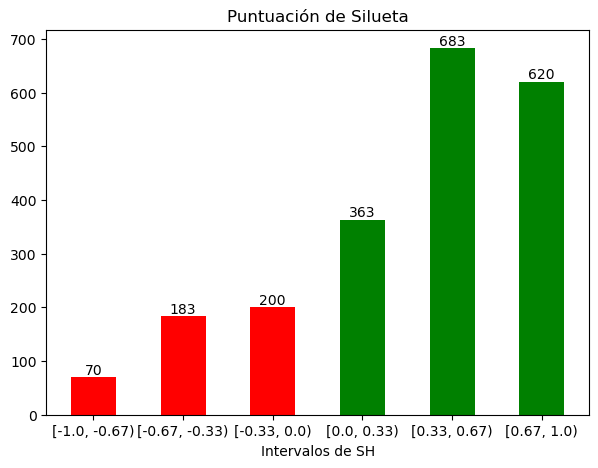

In [167]:
plt.figure(figsize=[10,6])

map_pose_sh_diagram=sh_bar(map_sh_score,xlabel='Puntuación de Silueta',k=6)

## VPR System Evaluation

Calculation and plot of the multiclass confusion matrix

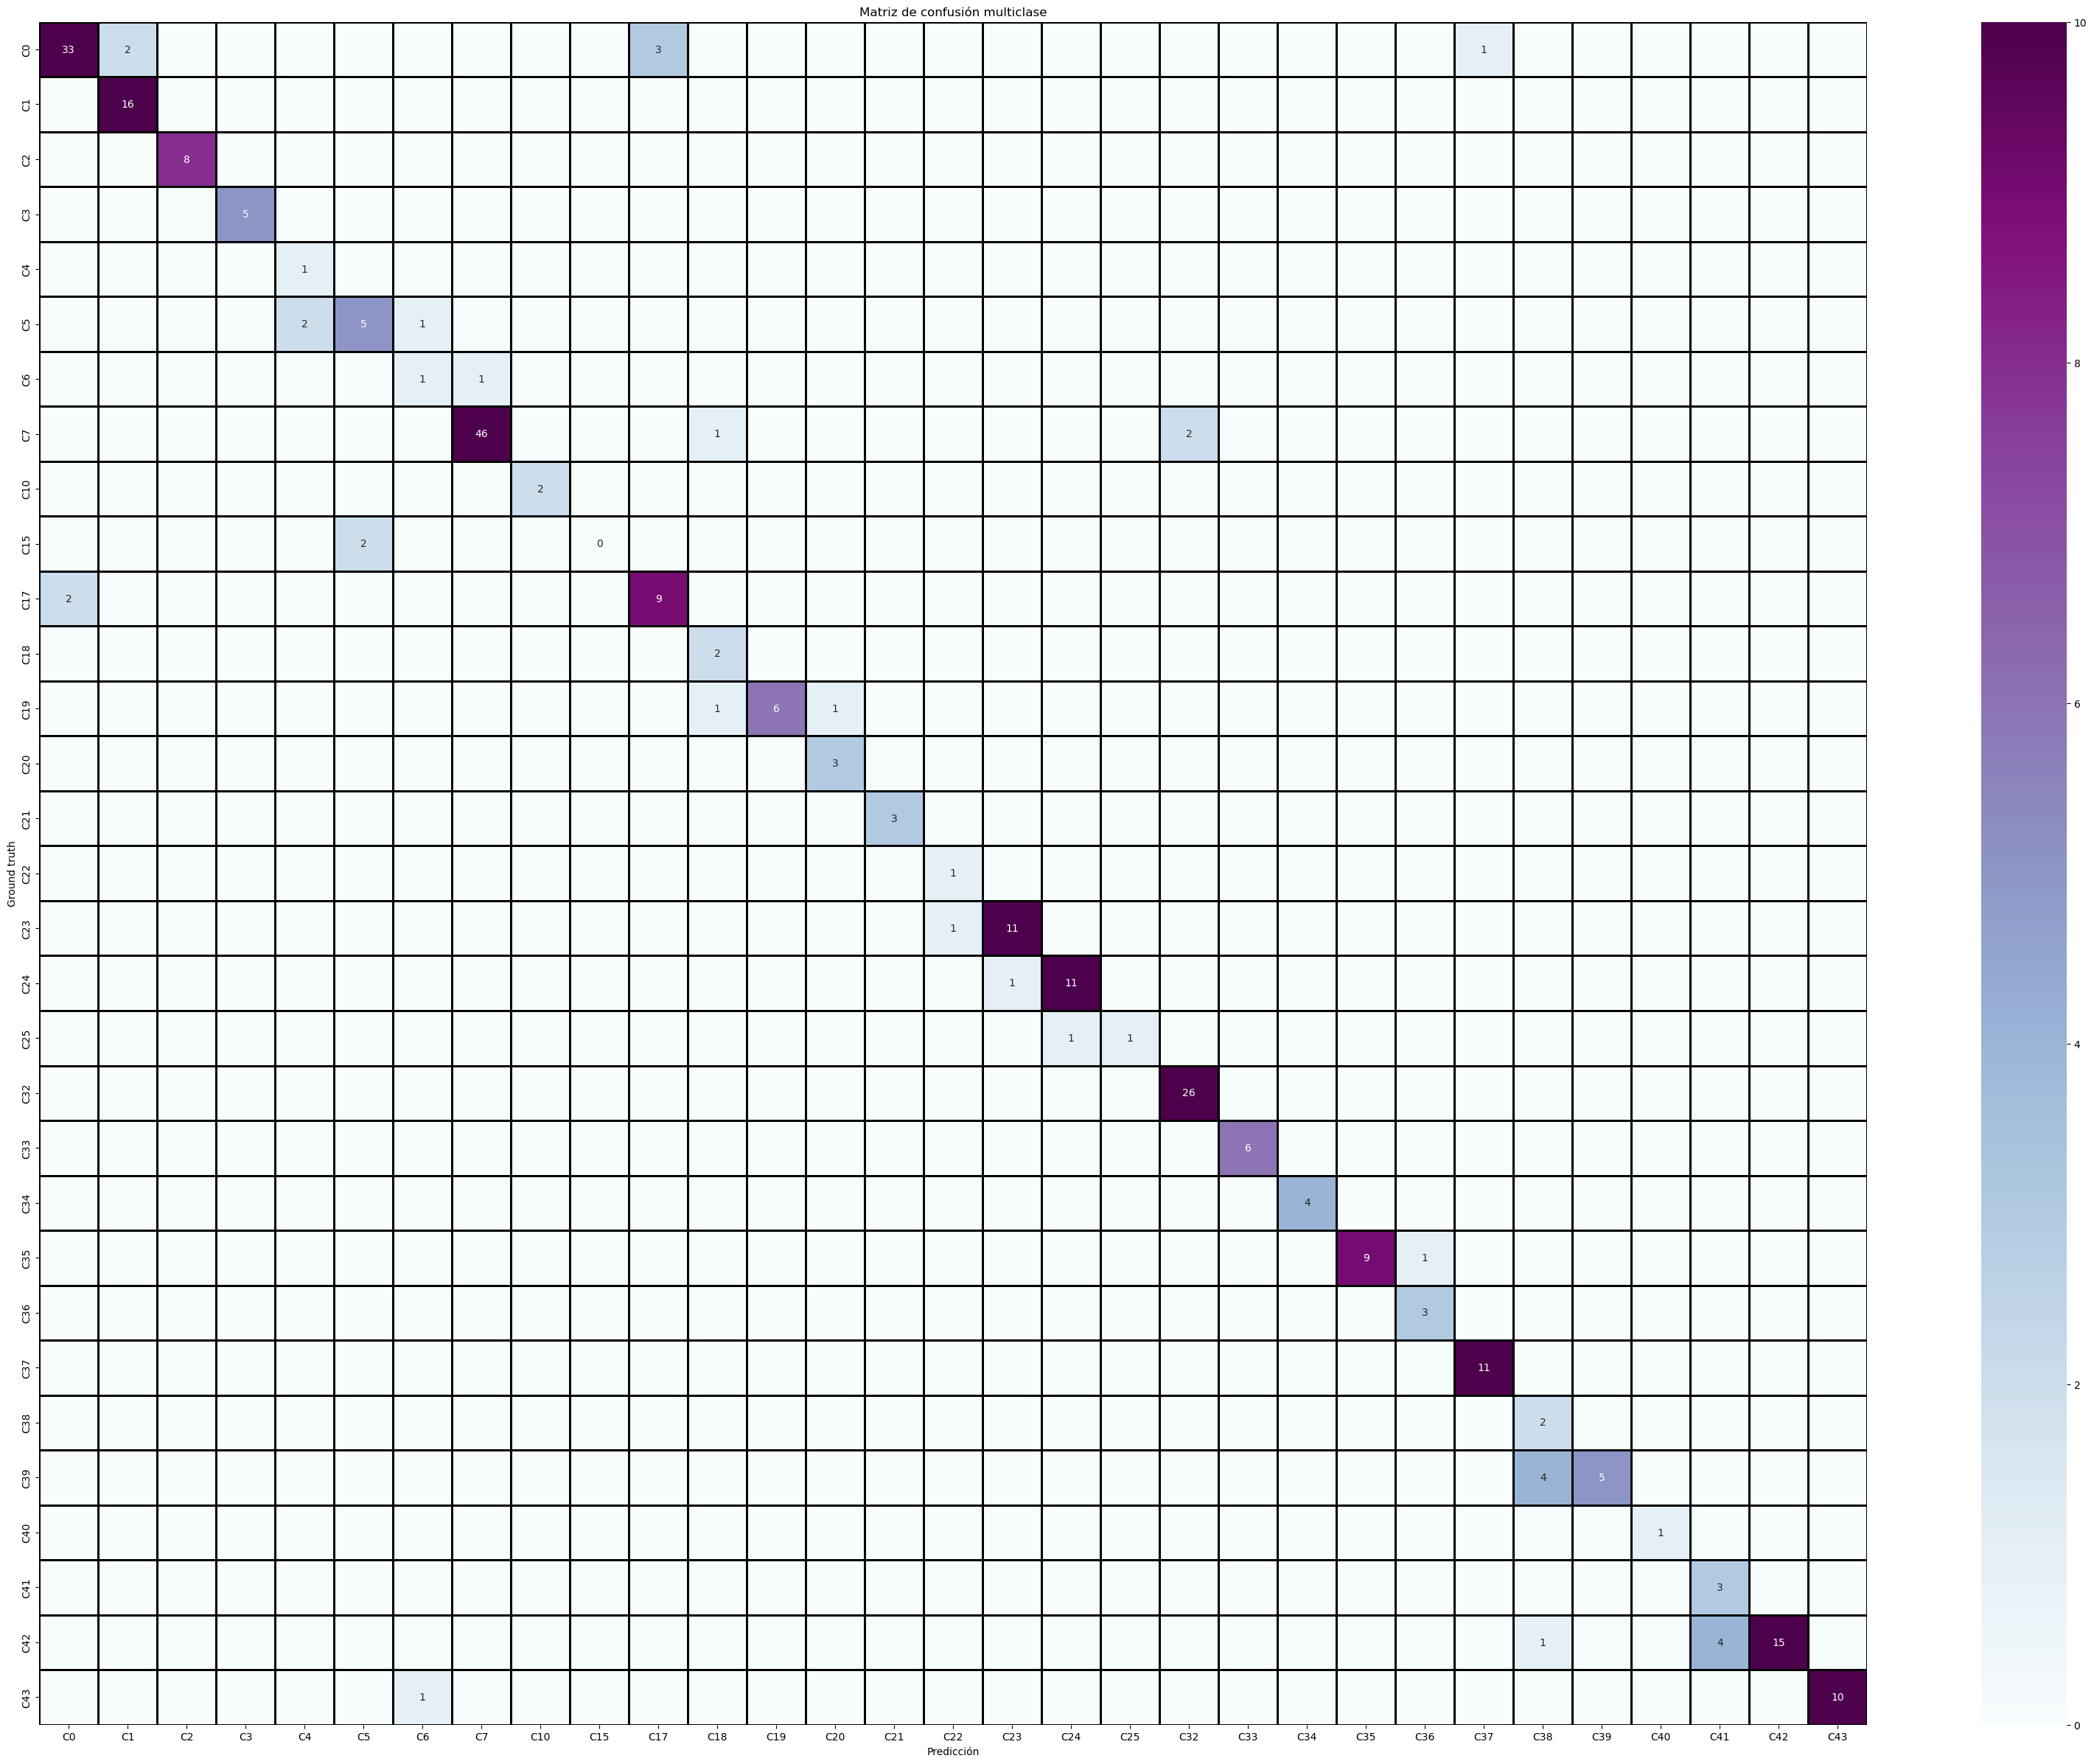

In [168]:
# Calculate ground-truth matrix (m x n) based on the closest pose on the map / m= nº of queries, n= nº of groups
query_GT=nearest(query_dataset['poses'][select_idx],map_dataset)

# Calculate prediction matrix (mxn) for queries based on appearance
query_predict=most_similar_centroid(query_dataset['feats'][select_idx],map_dataset)
query_predict=query_predict.tolist()

# List of groups visited for labels on the multiclass confusion matrix
visited_clusters=np.unique(np.union1d(query_GT,query_predict))
my_labels=["C"+str(i) for i in visited_clusters]

# Plot multiclass confusion matrix
cm_analysis(query_GT,query_predict,my_labels,figsize=(40,30))

### Precision and Recall at the groups

In [169]:

P, R= cluster_eval(query_dataset, map_dataset, select_idx, remove=True)

Bar Chart Plot

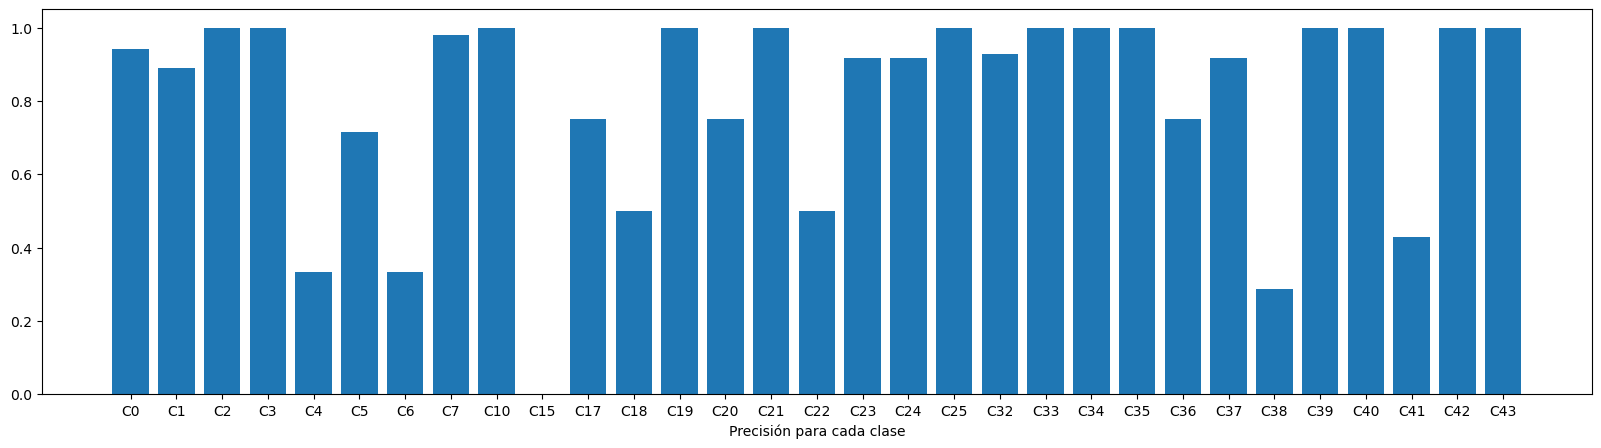

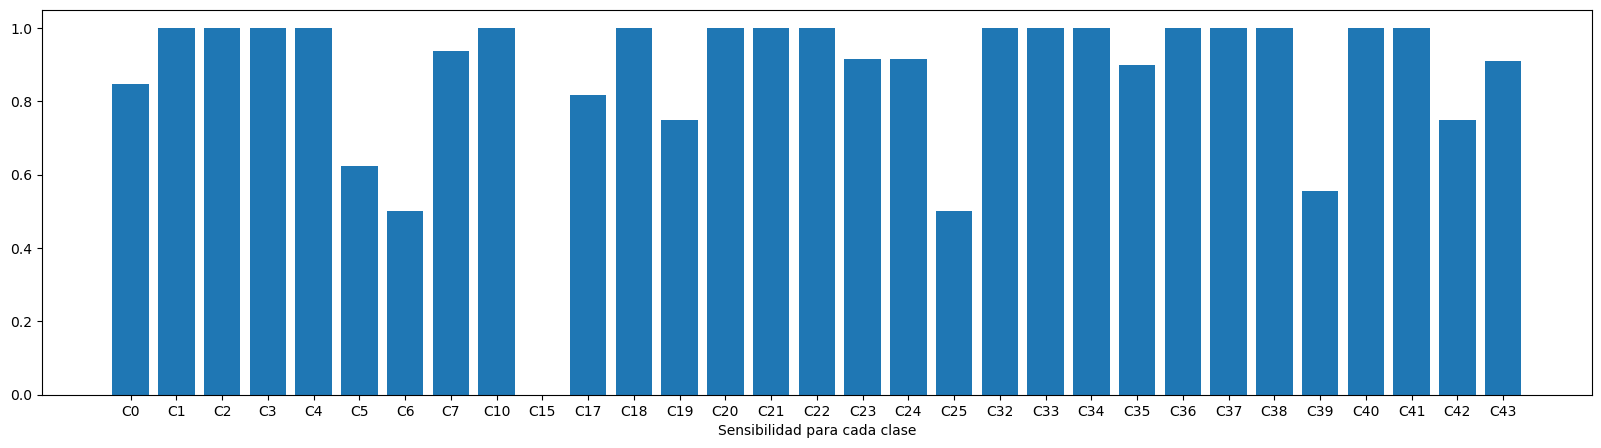

In [170]:
plt.figure(figsize=[20,5])
plt.bar(P[0],P[1],width=0.8)
plt.xlabel('Precisión para cada clase')
plt.show()

plt.figure(figsize=[20,5])
plt.bar(R[0],R[1],width=0.8)
plt.xlabel('Sensibilidad para cada clase')
plt.show()

Calculate the mean precision and sensitivity at the group level

In [171]:
P_mean=np.mean(P[1])
R_mean=np.mean(R[1])

### General Precision, Recall and Accuracy 

In [172]:
P_, R_, ACC_ =general_eval(query_dataset, map_dataset,select_idx)

Overall evaluation result

In [174]:
print('Mean SH score intra map: ',map_sh_score_mean,' ~ ',100*((map_sh_score_mean+1)/2),'%')
print('Mean Precission in clusters: ',100*P_mean,'%')
print('Mean Recall in clusters: ',100*R_mean,'%')
print('General Precision: ', 100*P_,'%')
print('General Recall: ',100*R_,'%')
print('General Accuracy: ',100*ACC_,'%')
print('Error :',100*(1-ACC_),'%')

Media SH score intra map:  0.5724398301085417  ~  78.62199150542708 %
Mean Precission in clusters:  80.11057728783581 %
Mean Recall in clusters:  86.85835797329572 %
Precision general:  88.6986301369863 %
Recall general:  88.6986301369863 %
Accuracy general:  99.27087936367653 %
Error : 0.7291206363234659 %


## Plot VPR map

In this section the topological map and the queries are plotted, indicating if they are well or badly classified.

In [175]:
# Calculate ground-truth matrix (m x n) based on the closest pose on the map / m= nº of queries, n= nº of groups
query_GT=nearest(query_dataset['poses'][select_idx],map_dataset)

# Calculate prediction matrix (mxn) for queries based on appearance
query_predict=most_similar_centroid(query_dataset['feats'][select_idx],map_dataset)
query_predict=query_predict.tolist()

# List of groups to which a query is assigned
visited_clusters=np.unique(np.union1d(query_GT,query_predict))

Plot the map

(-16.24954285, 6.53292785, -5.6359072, 4.6513412)

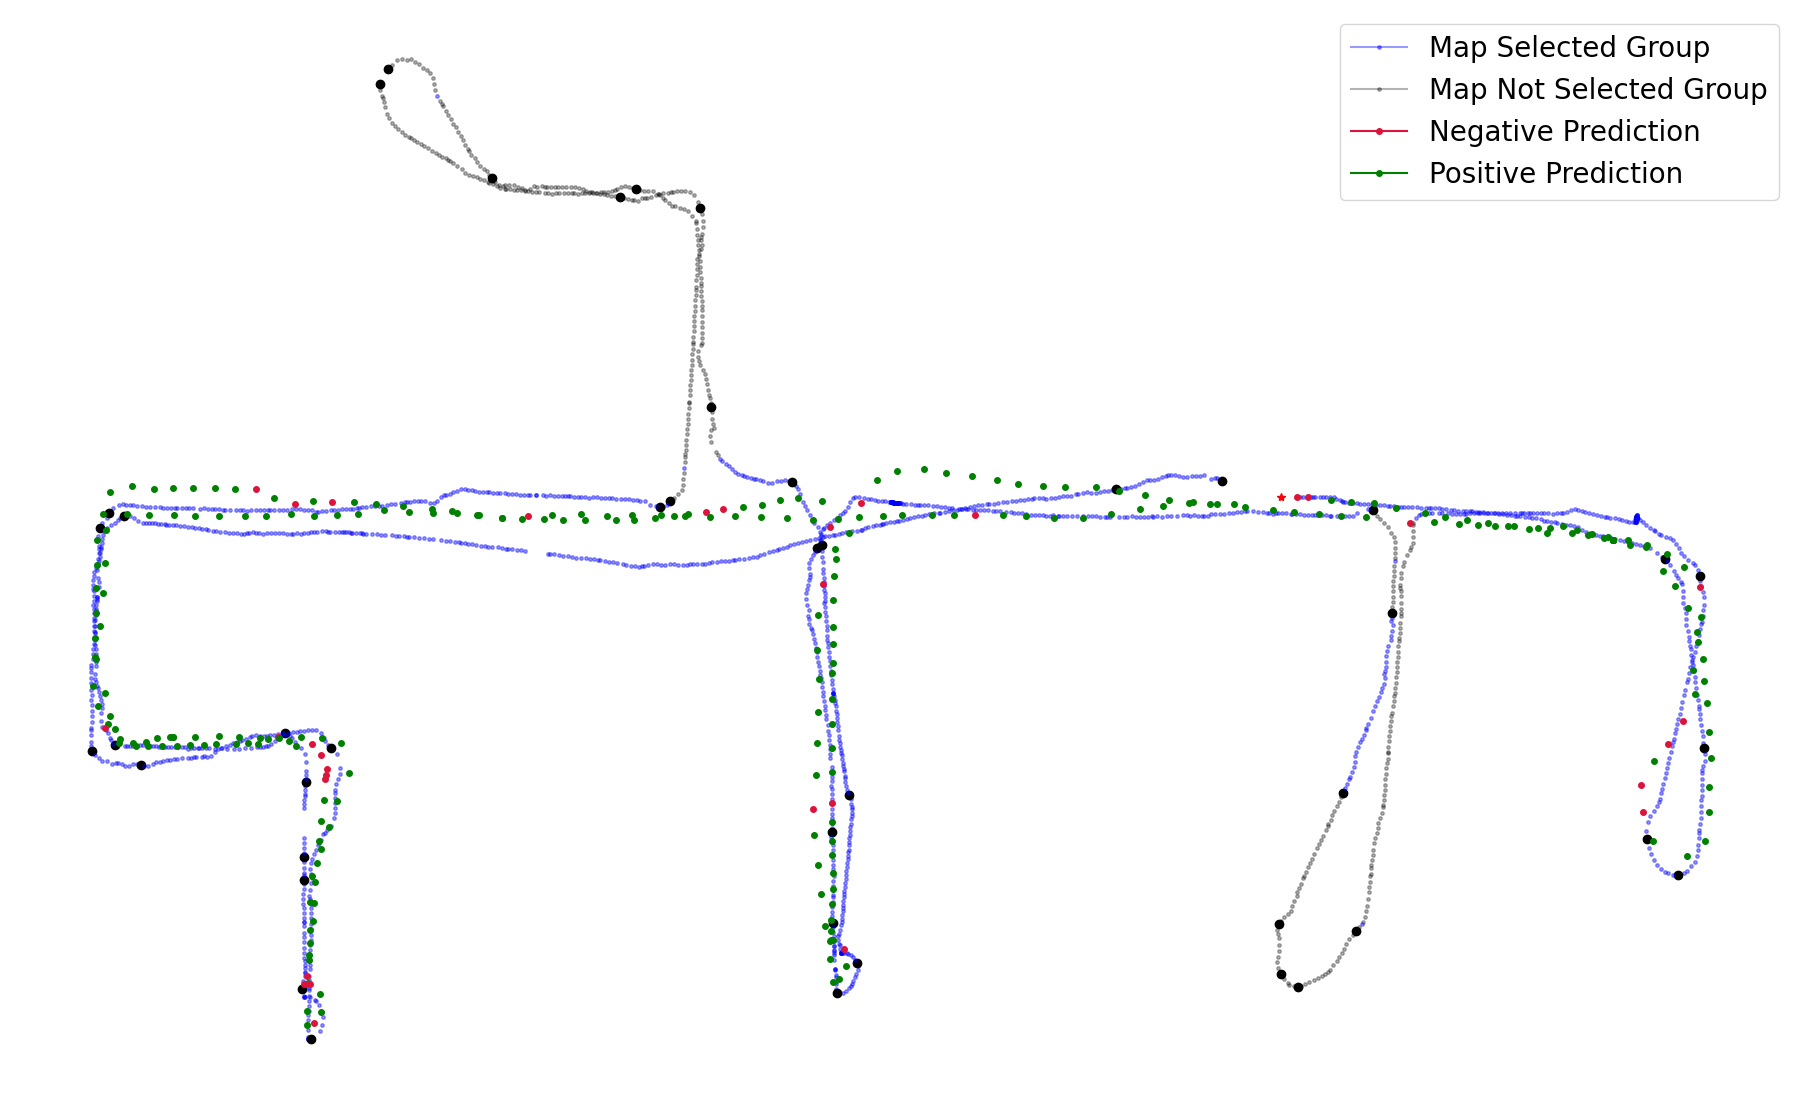

In [178]:
# Create the figure:
fig=plt.figure(figsize=(23,14))
ax = fig.add_subplot(111)
plt.plot(0,0,marker='*',color='red')    # Mark the origin of the map (0,0)

# Topological map plot
n_clusters=len(clusters_map)
for i in range(n_clusters):
    subgraph=np.copy(clusters_map[i])   # Copy the group

    for k,item in enumerate(clusters_map[i]):   # Loop through group items
        # Extract element position:
        translation=geo.SE2Poses.t(pose_map[item])
        new_x=translation[0]
        new_y=translation[1]
        # If it is a visited group it is plotted in blue, otherwise in grey:
        if i in visited_clusters:
            plt.plot(new_x,new_y,markersize=2.5,marker='o',color='b',alpha=0.4,label="Map Selected Group")
        else:
            plt.plot(new_x,new_y,markersize=2.5,marker='o',color='black',alpha=0.3,label="Map Not Selected Group")
    # Plot a black dot to delimit the groups
    plt.plot(new_x,new_y,markersize=6,marker='o',color='black')


# Plot the queries:
pose_consulta=[geo.SE2Poses.t(pose_test[j]) for j in range(len(pose_test))] # Query poses

for j in range(len(pose_consulta)):
    # If the prediction is correct, the position is plotted in green
    if query_GT[j] == query_predict[j]:
        plt.plot(pose_consulta[j][0],pose_consulta[j][1],markersize=4,marker='o',color='g',label='Positive Prediction')

    # If the prediction is not correct, the position is plotted in red
    else:
        plt.plot(pose_consulta[j][0],pose_consulta[j][1],markersize=4,marker='o',color='#DC143C',label="Negative Prediction")

# Show plot
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys(),fontsize="20")
plt.axis('off')

